In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import rgb2hex
from matplotlib import cm
import numpy as np
import networkx as nx
import datetime as dt
import random
import pickle
import math
import csv
import os

%matplotlib inline

### Visualizations & plots

In [ ]:
home_dir = os.path.expanduser("~")
code_dir = os.path.join(home_dir,"Developer","GitHub","opportunistic-attachment")
nets_dir = os.path.join(code_dir,"networks")
figs_dir = os.path.join(code_dir,"figures")

In [3]:
from src.models import InOneOutOne, InOneOutTwo, InTwoOutOne, InOutThree, InTwoOutTwo

In [4]:
m = 3
alpha = 0.95

# READY OUTPUT DIRECTORY
output = "_".join(["i1o1","m"+str(m),"a"+str(alpha)])
if not os.path.exists(os.path.join(figs_dir,output)):
    os.mkdir(os.path.join(figs_dir,output))

### Network growth -- visualization

In [5]:
def node_properties(G_list):

    N = G_list[-1].number_of_nodes()
    m = G_list[0].number_of_nodes()
    
    # LAYOUT
    pos = nx.kamada_kawai_layout(G_list[0])
    pos_list = [pos.copy()] * m
    # now loop through the added nodes
    for node in range(m,len(G_list)):
        G = G_list[node]
        # get the new node into position
        tmp = nx.spring_layout(G, pos=pos, fixed=pos.keys())
        pos[max(G.nodes)] = tmp[max(G.nodes)]
        # get the new layout
        pos = nx.kamada_kawai_layout(G, pos=pos)
        pos_list.append(pos)
        
    # COLOR
    age_map = [i+1 for i in range(N)]
    node_ages = {i:1 for i in range(m)}
    age_list = [node_ages.copy()] * m
    # now loop through the added nodes
    for node in range(m,len(G_list)):
        G = G_list[node]
        node_ages[max(G.nodes)] = age_map[node]
        age_list.append(node_ages.copy())

    # SIZE
    pr_list = []
    for G in G_list:
        scores = nx.get_node_attributes(G, 'score')
        max_score = max(scores.values())
        scores_norm = {node: score/max_score for node, score in scores.items()}
        pr_list.append(scores_norm)

    return pos_list, age_list, pr_list


In [ ]:
# NETWORK VIDEOS -- each jpg. Then there's a gif script in the src directory to call from the command line.
runs = [3,4,5,6,7,8,9,10]
gammas = ["rnd",0,1,2,3,4,5,6,7,8,9,"inf"]

for run in runs:
    for gamma in gammas:
        
        network = "_".join(["i1o1","m"+str(m),"a"+str(alpha),"g"+str(gamma)])

        # LOAD RUN
        with open(os.path.join(nets_dir,network,"run_"+str(run)+'.pkl'), 'rb') as f:
            model = pickle.load(f)

        # UNPACK
        networks = model.networks
        
        # READY OUTPUT DIRECTORY
        try:
            os.mkdir(os.path.join(nets_dir,network,"pdfs_"+str(run)))
            os.mkdir(os.path.join(nets_dir,network,"jpeg_"+str(run)))
        except:
            pass

        # NODE PROPERTIES
        pos_list, age_list, pr_list = node_properties(networks)
        
        # MAKE PLOTS
        for i, G in enumerate(networks):

            # initialize figure
            fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4.5,4))

            # format node properties
            pos = pos_list[i]
            age = [age_list[i][node] for node in G.nodes]
            pr_rel = [10+200*pr_list[i][node] for node in G.nodes]

            # draw network
            nx.draw_networkx_nodes(G, pos, node_size=pr_rel, node_color=age, linewidths=1.5,
                                edgecolors='#333333', cmap='BuPu', ax=ax)
            nx.draw_networkx_edges(G, pos, edge_color='#999999', ax=ax, width=2, alpha=0.6)
            ax.set_axis_off()

            # draw colorbar
            cmap = plt.colormaps['BuPu']
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 1, vmax = i+1))
            sm.set_array([])
            plt.colorbar(sm, ax=ax)

            # save figure
            plt.savefig(os.path.join(nets_dir,network,"jpeg_"+str(run),"N_"+str(G.number_of_nodes())+".jpeg"), bbox_inches='tight', dpi=300)
            plt.savefig(os.path.join(nets_dir,network,"pdfs_"+str(run),"N_"+str(G.number_of_nodes())+".pdf"), bbox_inches='tight')
            plt.close()

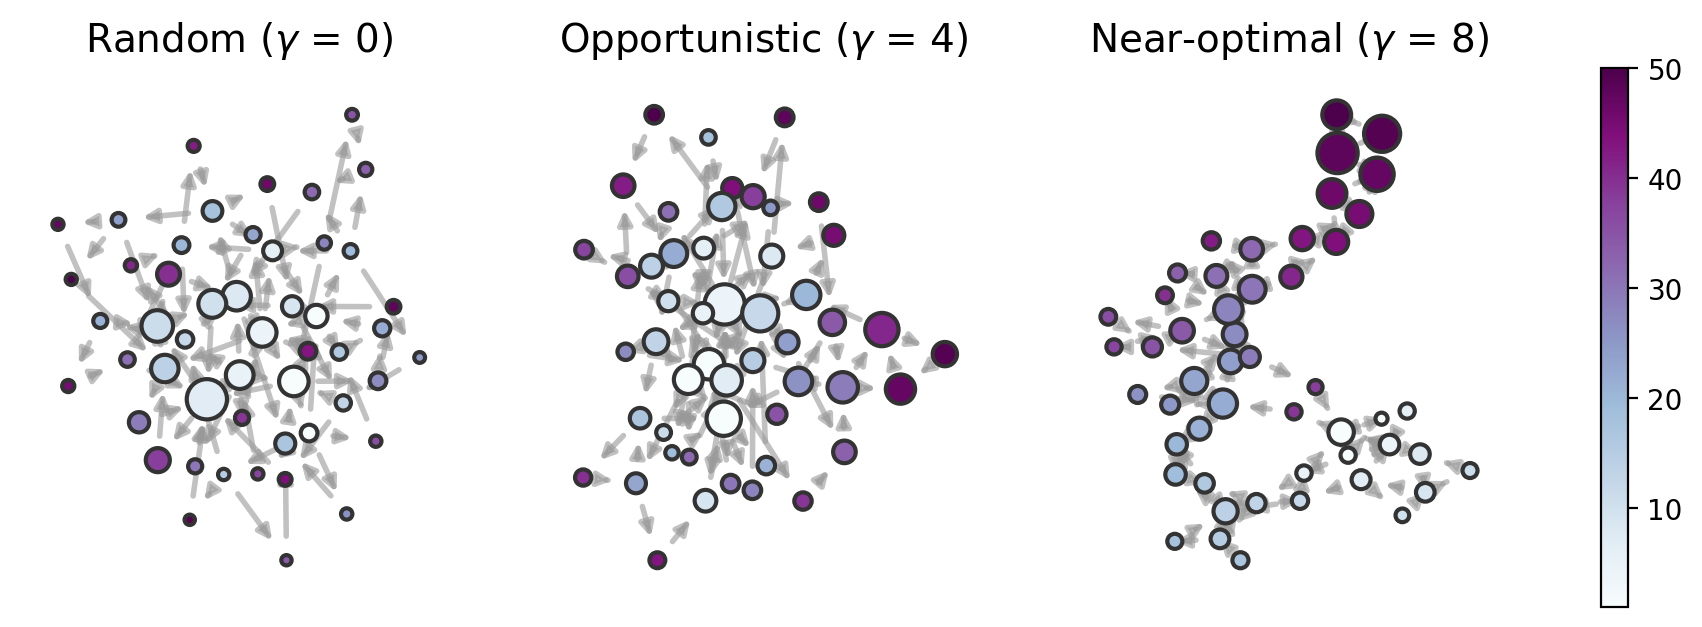

In [6]:
# PICK YOUR FAVORITES
plot_gammas = [0,4,8]
fave_run = {0:2,4:0,8:2}
n_i = 50

plot_network = {}
plot_nodes = {}
for gamma in plot_gammas:
       
    # LOAD RUN
    network = "_".join(["i1o1","m"+str(m),"a"+str(alpha),"g"+str(gamma)])
    run = fave_run[gamma]

    with open(os.path.join(nets_dir,network,"run_"+str(run)+'.pkl'), 'rb') as f:
        model = pickle.load(f)

    # UNPACK
    networks = model.networks
    plot_network[gamma] = networks[n_i-1]

    # NODE PROPERTIES
    pos_list, age_list, pr_list = node_properties(networks)
    plot_nodes[gamma] = {'pos':pos_list[n_i-1], 'age':age_list[n_i-1], 'pr_rel':pr_list[n_i-1]}

#initialize figure
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12,3.5))

# draw networks
for ax_i, gamma in enumerate(plot_gammas):

    # Grab network & node properties
    G = plot_network[gamma]
    pos = plot_nodes[gamma]['pos']
    age = [plot_nodes[gamma]["age"][node] for node in G.nodes]
    pr_rel = [10+200*plot_nodes[gamma]["pr_rel"][node] for node in G.nodes]

    nx.draw_networkx_nodes(G, pos, node_size=pr_rel, node_color=age, linewidths=1.5,
                        edgecolors='#333333', cmap='BuPu', ax=ax[ax_i])
    nx.draw_networkx_edges(G, pos, edge_color='#999999', ax=ax[ax_i], width=2, alpha=0.6)
    ax[ax_i].set_axis_off()
    ax_i += 1

# draw colorbar
cmap = plt.colormaps['BuPu']
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 1, vmax = n_i))
sm.set_array([])
fig.colorbar(sm, ax=ax.ravel().tolist())

ax[0].set_title("Random ("+r'$\gamma$'+f' = {plot_gammas[0]})', fontsize=14)
ax[1].set_title("Opportunistic ("+r'$\gamma$'+f' = {plot_gammas[1]})', fontsize=14)
ax[2].set_title("Near-optimal ("+r'$\gamma$'+f' = {plot_gammas[2]})', fontsize=14)

plt.savefig(os.path.join(figs_dir,output,"networks.jpeg"), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(figs_dir,output,"networks.pdf"), bbox_inches='tight')
plt.show()
plt.close()
# Note that the nodes here are sized by realized pagerank; that is the score.


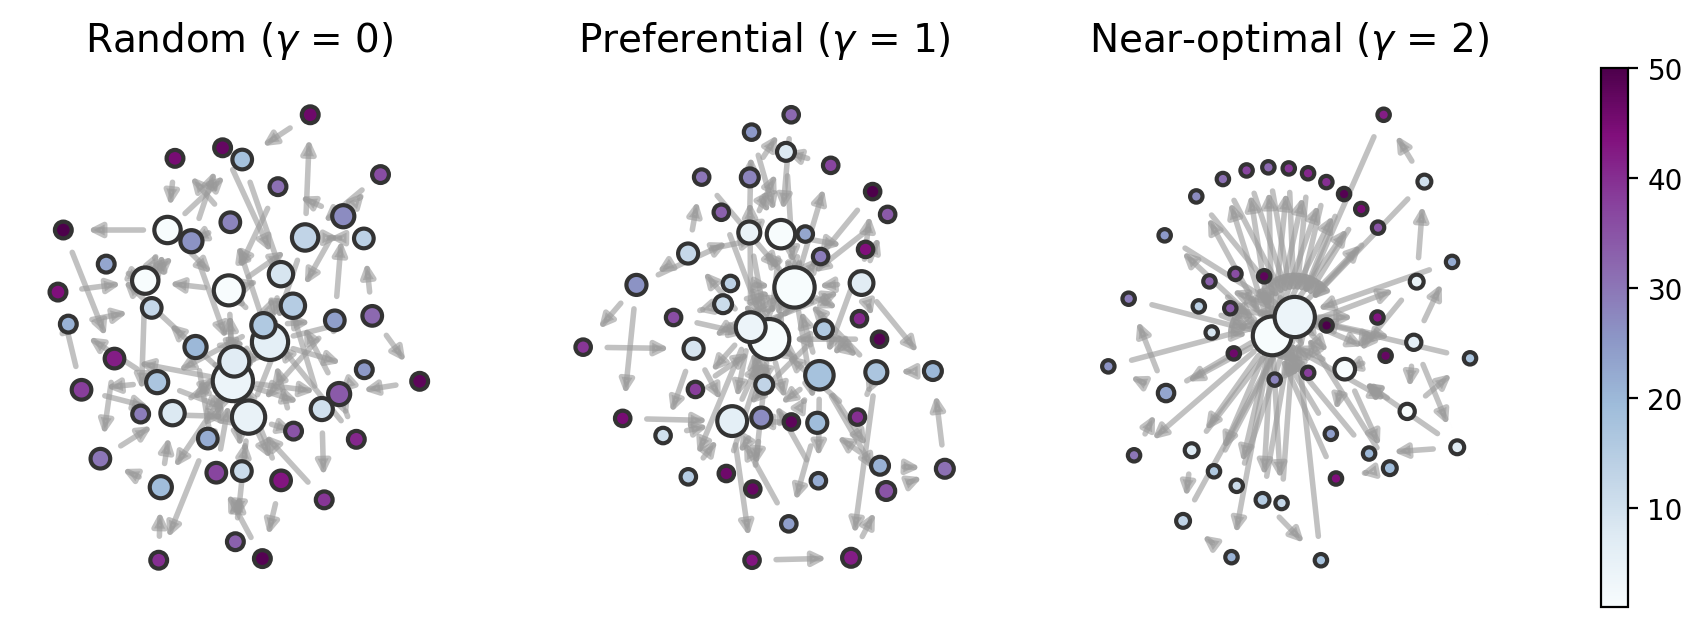

In [7]:
# By the way, this is what the analogous plot looks like for preferential attachment.
from src.base import Exogenous

pref_attachment = {0:{},1:{},2:{}}

for run in range(10):
    # INITIALIZE MODEL
    pref_attachment[0][run] = Exogenous(m=3,select="random")
    pref_attachment[0][run].grow(50)
    pref_attachment[1][run] = Exogenous(m=3,select="preferential")
    pref_attachment[1][run].grow(50)
    pref_attachment[2][run] = Exogenous(m=3,select="preferential",gamma=2)
    pref_attachment[2][run].grow(50)

# PICK YOUR FAVORITES
plot_gammas = [0,1,2]
fave_run = {0:0,1:0,2:0}
n_i = 50

plot_network = {}
plot_nodes = {}
for gamma in plot_gammas:
       
    # LOAD RUN
    model = pref_attachment[gamma][fave_run[gamma]]

    # UNPACK
    networks = model.networks
    plot_network[gamma] = networks[n_i-1]

    # NODE PROPERTIES
    pos_list, age_list, pr_list = node_properties(networks)
    plot_nodes[gamma] = {'pos':pos_list[n_i-1], 'age':age_list[n_i-1], 'pr_rel':pr_list[n_i-1]}

#initialize figure
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12,3.5))

# draw networks
for ax_i, gamma in enumerate(plot_gammas):

    # Grab network & node properties
    G = plot_network[gamma]
    pos = plot_nodes[gamma]['pos']
    age = [plot_nodes[gamma]["age"][node] for node in G.nodes]
    pr_rel = [10+200*plot_nodes[gamma]["pr_rel"][node] for node in G.nodes]

    nx.draw_networkx_nodes(G, pos, node_size=pr_rel, node_color=age, linewidths=1.5,
                        edgecolors='#333333', cmap='BuPu', ax=ax[ax_i])
    nx.draw_networkx_edges(G, pos, edge_color='#999999', ax=ax[ax_i], width=2, alpha=0.6)
    ax[ax_i].set_axis_off()
    ax_i += 1

# draw colorbar
cmap = plt.colormaps['BuPu']
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 1, vmax = n_i))
sm.set_array([])
fig.colorbar(sm, ax=ax.ravel().tolist())

ax[0].set_title("Random ("+r'$\gamma$'+f' = {plot_gammas[0]})', fontsize=14)
ax[1].set_title("Preferential ("+r'$\gamma$'+f' = {plot_gammas[1]})', fontsize=14)
ax[2].set_title("Near-optimal ("+r'$\gamma$'+f' = {plot_gammas[2]})', fontsize=14)

plt.savefig(os.path.join(figs_dir,output,"networks_pref.jpeg"), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(figs_dir,output,"networks_pref.pdf"), bbox_inches='tight')
plt.show()
plt.close()
# Note that the nodes here are sized by degree, because that is the score for PA.

## Path dependence

In [8]:
# Example of a case where one link makes a big difference
# nets/i1o1_m3_a0.95_g8/run_1.pkl from 47 to 48
# networks/i1o1_m3_a0.95_g8/run_1.pkl from 55 to 56
# networks/i1o1_m3_a0.95_g7/run_2.pkl from 45 to 46
# networks/i1o1_m3_a0.95_g8/run_4.pkl from 44 to 45
# networks/i1o1_m3_a0.95_g8/run_5.pkl from 76 to 77
# networks/i1o1_m3_a0.95_g8/run_8.pkl from 93 to 94

# NETWORK VISUALIZATIONS -- these are used later for plotting within plot_space.py
examples = []
examples.append({'gamma':8, 'run':-1, 'n_i':48})
examples.append({'gamma':8, 'run':1, 'n_i':56})
examples.append({'gamma':8, 'run':5, 'n_i':77})
examples.append({'gamma':8, 'run':8, 'n_i':94})
examples.append({'gamma':8, 'run':4, 'n_i':45})
examples.append({'gamma':7, 'run':2, 'n_i':46})

around = 5

for example in examples:
        
        # LOAD RUN
        network = "_".join(["i1o1","m"+str(m),"a"+str(alpha),"g"+str(example['gamma'])])
        example["label"] = "_".join([network,"r"+str(example["run"])])
    
        with open(os.path.join(nets_dir,network,"run_"+str(example['run'])+'.pkl'), 'rb') as f:
            model = pickle.load(f)
    
        # SELECT NETWORK
        networks = model.networks
        idx = example["n_i"]+around-1

        # NODE PROPERTIES
        G = networks[idx]
        pos_list, age_list, pr_list = node_properties(networks)
        pos = pos_list[idx]
        ages = [age_list[idx][node] for node in G.nodes]
        pr_rel = [10+200*pr_list[idx][node] for node in G.nodes]

        # Grab colors matching the examples
        color = {}
        for term, cmap_name in zip(["pre","post","rest"],["Blues","BuPu","Greys"]):
            cmap = plt.colormaps[cmap_name]
            color[term] = [rgb2hex(cmap(i)) for i in np.linspace(0, 0.8, idx+1)]

        # pre- and post- nodes
        post_nodes = set(sorted(list(G.nodes))[-around:])
        pre_nodes = set(sorted(list(G.nodes))[-2*around:-around])
        colors = []
        for node, age in zip(G.nodes,ages):
            if node in post_nodes:
                colors.append(color["post"][age-1])
            elif node in pre_nodes:
                colors.append(color["pre"][age-1])
            else:
                colors.append(color["rest"][age-1])

        # highlight the key node
        borders = ['#333333' if age_list[idx][node] != example["n_i"] else "#800000" for node in G.nodes]

        # READY OUTPUT DIRECTORY
        if not os.path.exists(os.path.join(figs_dir,output,"examples")):
            os.mkdir(os.path.join(figs_dir,output,"examples"))

        # save network visualization as a pickle
        with open(os.path.join(figs_dir,output,"examples",f"{example['label']}.pickle"), 'wb') as f:
            pickle.dump((G, pos, pr_rel, colors, borders), f)